## Google Drive
### Mounting Google Drive locally
The example below shows how to mount your Google Drive in your virtual machine using an authorization code, and shows a couple of ways to write & read files there. Once executed, observe the new file (foo.txt) is visible in https://drive.google.com/

Note this only supports reading and writing files; to programmatically change sharing settings etc use one of the other options below.



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir("gdrive/My Drive/Enlitic test")

## Jupyter Notebook
#### The cells describe the steps of the entire processes, while the .py codes are saved separately.



- Only Python + "Numpy" environment is used.<br> 
- "Matplotlib" is loaded only for visualization purpose.<br>
- "gzip" and "pickle" are only for unpickling the datasets.<br>
- "time" is loaded only for measuring the running time.

In [0]:
%matplotlib inline

import gzip, pickle # for the purpose of "unzipping" and "unpickling" objects produced with cPickle
import numpy as np
import matplotlib.pyplot as plt # for the purpose of visualization

### Data preprocessing
##### The purpose of class "Data_loading" is to:
- <font color=purple> <b>Unzip and/ or unpickle the dataset
- Shuffle the original training sets through setting a random seed so that the result can be reproducible.
- Scale the pixel values between 0 and 1 (only for CIFAR100 dataset). 
- Selected the first 10K shuffled images as the new trainging set, and the second 10K shuffled images as the validation set
- Keep the same test set </b></font>


In [0]:
######################################################################
# Data loading class
#    datasets are from either MNIST or CIFAR100
######################################################################

class Data_loading():
    def __init__(self, file):
        self.file = file    # initialze/ load the filename/ filepath
        self.train = []     #initialize self.train
        self.val = []       #initialize self.val
        self.test = []      #initialize self.test
        
    def unpickle(self):
        # load the folder containing 'cifar-100-python/train' and 'cifar-100-python/test'
        assert self.file == 'cifar-100-python'
        file_path = ['/'.join([self.file, 'train']), '/'.join([self.file, 'test'])]
        for file in file_path:
            with open(file, 'rb') as f:
                dic = pickle.load(f, encoding='bytes')
                if file.split('/')[1] == 'train':
                    self.train = dic[b'data']
                else:
                    self.test = dic[b'data']
            f.close()
    
    def unzip_unpickle(self):  
        # load 'mnist.pkl.gz' file containing 'train', 'validation' and 'test' tuples
        assert self.file == 'mnist.pkl.gz'
        with gzip.open(self.file, 'rb') as f:
            dict = pickle._Unpickler(f, encoding='latin1')
            train_set, __, test_set = dict.load()
            self.train, self.test = train_set[0], test_set[0]
            f.close()
            
    def preprocess(self):
        np.random.seed(123)  # set random seed
        if 'cifar' in self.file:
            self.unpickle()      
        elif 'mnist' in self.file:
            self.unzip_unpickle()
        np.random.shuffle(self.train)
        self.val = self.train[10000:20000]  #update the validation set after shuffling
        self.train = self.train[:10000]     #update the training set after shuffling
        
        if 'cifar' in self.file:
            self.train = self.train/255. # scale pixel values between 0 and 1
            self.val = self.val/255. # scale pixel values between 0 and 1
            self.test = self.test/255. # scale pixel values between 0 and 1

### The function of visualization codes
- **generate photo-montage to verify the correctness of preprocessing both the datasets**

In [0]:
######################################################################
# Data visualization using photographic montage
#   image pixel values are scaled between 0 and 1
#   MNIST: 28 x 28 pixels with 1 channel (grayscale)
#   CIFAR200: 32 x 32 pixels with 3 channels (RGB)
######################################################################        

def image_montage(img_data, num_row = 20, num_col = 20, dataset = None):
    # total number of images for visualization 
    num_img = num_row * num_col
    imgs = img_data[:num_img]

    if dataset =='cifar':
        img_dim = int((imgs.shape[1]/3)**0.5)
        # reshape the Numpy array
        img_viz = img_data[:num_img].reshape(num_img, 3, img_dim, -1).transpose(0,2,3,1)
        img_mont = img_viz.reshape(num_row, num_col, img_dim, -1, 3)\
        .reshape(num_row, num_col*img_dim, -1, 3).transpose(1,0,2,3).reshape(num_row*img_dim, -1, 3)
    
    elif dataset == 'mnist':
        img_dim = int(imgs.shape[1]**0.5)
        # reshape the Numpy array
        img_viz = img_data[:num_img].reshape(num_img, img_dim, img_dim)
        img_mont = img_viz.reshape(num_row, num_col, -1, img_dim).reshape(num_row, num_col*img_dim, -1)\
        .transpose(1,0,2).reshape(-1, num_row*img_dim)
    
    fig, ax = plt.subplots(figsize = (img_dim//4, img_dim//4))
    ax.imshow(img_mont, cmap='gray')  # cmap is ignored for RGB(A) data
    ax.axis('off') # clear x- and y-axes
    plt.show()


#### Create objects from MNIST and CIFAR100 datasets and present 400 images in the montaged figures

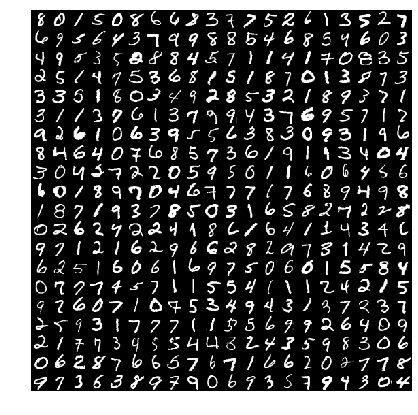

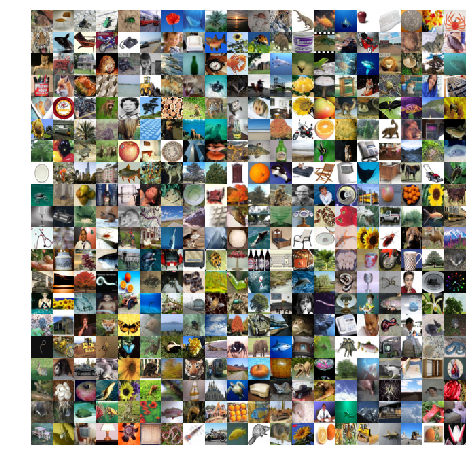

In [6]:
def main():
    cifar_file = 'cifar-100-python'
    mnist_file = 'mnist.pkl.gz'
    # object MNIST
    mnist = Data_loading(mnist_file)
    mnist.preprocess()
    image_montage(mnist.train, dataset = 'mnist')
    # object cifar100
    cifar = Data_loading(cifar_file)
    cifar.preprocess()
    image_montage(cifar.train, dataset = 'cifar')
    
if __name__ == '__main__':
    main()

### Define the LogSumExp
The LogSumExp (LSE) function is a smooth maximum – a smooth approximation to the maximum function (https://en.wikipedia.org/wiki/LogSumExp). It's defined as the logarithm of the sum of the exponentials of the arguments:

$$LSE(x_{1},\dots ,x_{n})=\log(\exp(x_{1}) +\cdots +\exp(x_{n}))$$

As the function needs to work for $x$ with very large and very small components, a large $x_{i}$ can cause overflow due to the exponentiation, while the exponential term of a very negative $x_{i}$ of large absolute value can vanish, resulting in underflow. <br>

A simple transformation can avoid both the issues: 

$$LSE(x_{1},\dots ,x_{n})= x^* +\log(\exp(x_{1}-x^*) +\cdots +\exp(x_{n}-x^*))
 \\= x^* + \sum_{i=1}^n \exp(x_{i}-x^*)$$
where $x^* = \max\{x_i, \cdots, x_n\}$ <br>
<br>
In machine learning, one common place is calculating the cross entropy loss of the softmax function. 

In [0]:
######################################################################
# Arithmetic underflow can become a problem when multiplying together 
# many small probabilities. It can be useful to calculate the log sum
# of exponentials. If the exponent is sufficiently large or small, this  
# results in an arithmetic overflow/underflow. To avoid this we can use 
# a common trick called the Log Sum Exponential trick.
######################################################################  

def logSumExp(exp_terms, axis = 1):
    maximum = np.max(exp_terms, axis = axis)
    diff = exp_terms - maximum[:, np.newaxis]
    sumOfExp = np.exp(diff).sum(axis = axis)
    
    return maximum + np.log(sumOfExp)


### Kernal Density Estimation with Gaussian Mixture Models
> _In density estimation, it is the value of the mixture likelihood at individual points that is of interest, rather than the membership of the components, tackled by clustering, discriminant or classification analysis._

In [0]:
######################################################################
#  Kernal density estimation with Gaussian Mixture Models
######################################################################   
import time
from tqdm import tqdm  # only for the purpose of monitoring the calculation progress

class GMM_KDE():
    '''
    mode: either "training" or "inference"
    '''
    def __init__(self, K, sigma, means):
        assert K == means.shape[0]
        self.K = K
        self.sigma = sigma
        self.means = means

   
    def KDE_eval(self, mode, val_dataset, batch_size = 100):
        # the size of batch_size depends on the physical memory in the device
        # operated.
        assert mode == 'inference'
        assert self.means.shape[1] == val_dataset.shape[1]
        means = self.means
        sigma = self.sigma
        lse_assem = []
        start = time.time()
        
        # Take the advatage of NumPy's power to reduce the useage of "for loop"
        # including vectorization and broadcasting.
        # If the memory capacity is big enough to load all the broadcasted matrices 
        # containing all the images, the for-loop below can be removed as well.
        
        for i in tqdm(range(val_dataset.shape[0] // batch_size)):
            V = val_dataset[i*batch_size:(i+1)*batch_size, np.newaxis, :]
            exponent = np.sum(-np.square(V-means)/(2*sigma**2) -\
                              0.5*np.log(2*np.pi*sigma**2), axis=2)
            lse = logSumExp(exponent, axis=1) - np.log(means.shape[0]) 
            lse_assem = np.concatenate((lse_assem, lse), axis = 0)
 
        time_dur = time.time()-start
        print("total time: ",time_dur//60, "min", time_dur%60, " sec")  
        mean_logProb = sum(lse_assem)/len(lse_assem)
        
        return mean_logProb, time_dur

### A preliminary code testing

In [0]:
#cifar_file = 'cifar-100-python'
mnist_file = 'mnist.pkl.gz'
# object MNIST
mnist = Data_loading(mnist_file)
mnist.preprocess()

mnist_gmm = GMM_KDE(K = mnist.train.shape[0], sigma = 0.5, means = mnist.train)
mnist_avgLogProb_sig_0_5, __ = mnist_gmm.KDE_eval('inference', mnist.val, batch_size = 100)

100%|██████████| 100/100 [08:11<00:00,  4.93s/it]

total time:  8.0 min 11.568568229675293  sec


In [0]:
# sigma = 0.5 on MNIST dataset

print(mnist_avgLogProb_sig_0_5)

-233.72675554351807


### Show time
> **Save the outcome of the mean of the log probability shown in Equation 6 and running time**

In [0]:
def output_save(dictionary, duration, filename):
    np_arr = np.zeros((len(dictionary)+1,2))
    i = 0
    for key, value in dictionary.items():
        np_arr[i,0], np_arr[i,1] =key, value
        i += 1
    np_arr[i,0], np_arr[i,1] = duration//60, duration%60
    np.savetxt(filename, np_arr, delimiter = ',')

### Grid-search for the optimal value of $\sigma$ on MNIST dataset


In [0]:
if __name__ == '__main__':
    mnist_file = 'mnist.pkl.gz'
    # object mnist
    mnist = Data_loading(mnist_file)
    mnist.preprocess() 
    train, val, test = mnist.train, mnist.val, mnist.test

    SIGMA = [0.05, 0.08, 0.1, 0.2, 0.5, 1., 1.5, 2.]
    
    mnist_mlogProb = dict()
    for sig in SIGMA:
        mnist_gmm = GMM_KDE(K=train.shape[0], sigma = sig, means = train)
        mnist_mlogProb[sig], duration = mnist_gmm.KDE_eval('inference', val, batch_size = 100)
        
    output_save(mnist_mlogProb, duration, filename = 'mnist_avgLogProb_val.txt')
   

100%|████████████████████████████████████████| 100/100 [10:13<00:00,  5.97s/it]


total time:  10.0 min 13.963492155075073  sec


100%|████████████████████████████████████████| 100/100 [09:52<00:00,  6.05s/it]


total time:  9.0 min 52.87989068031311  sec


100%|████████████████████████████████████████| 100/100 [10:11<00:00,  6.19s/it]


total time:  10.0 min 11.505104303359985  sec


100%|████████████████████████████████████████| 100/100 [10:23<00:00,  6.40s/it]


total time:  10.0 min 23.543272972106934  sec


100%|████████████████████████████████████████| 100/100 [10:31<00:00,  6.33s/it]


total time:  10.0 min 31.852437496185303  sec


100%|████████████████████████████████████████| 100/100 [10:10<00:00,  6.24s/it]


total time:  10.0 min 10.65599250793457  sec


100%|████████████████████████████████████████| 100/100 [10:32<00:00,  6.58s/it]


total time:  10.0 min 32.20085692405701  sec


100%|████████████████████████████████████████| 100/100 [10:47<00:00,  6.46s/it]


total time:  10.0 min 47.58354449272156  sec


Examine the result of the mean of log probability on MNIST dataset <br>
The mean log_prob at $\sigma = 0.2$ is optimal. 
With the optimal $\sigma$, compute $L_{D_{B}}$:  

In [0]:
mnist_mlogProb

{0.05: -3146.4204931815148,
 0.08: -610.9744572872162,
 0.1: -115.77980065045357,
 0.2: 234.32613628687858,
 0.5: -233.72675554351807,
 1.0: -740.8657432556153,
 1.5: -1051.1149543945312,
 2.0: -1272.9519045288087}

In [0]:
mnist_gmm = GMM_KDE(K=train.shape[0], sigma = 0.2, means = train)
mnist_mlogProb_test, __ = mnist_gmm.KDE_eval('inference', test, batch_size = 100)

100%|████████████████████████████████████████| 100/100 [10:08<00:00,  6.43s/it]


total time:  10.0 min 8.596739292144775  sec


In [0]:
# The corresponding averaged log probablility on the test set is:
mnist_mlogProb_test

234.19279673929213

### Grid-search for the optimal value of  σ  on CIFAR100 dataset
The same procedure shown above will go on the CIFAR100 dataset

In [0]:
if __name__ == '__main__':
    cifar_file = 'cifar-100-python'
    # mnist_file = 'mnist.pkl.gz'
    # object cifar
    cifar = Data_loading(cifar_file)
    cifar.preprocess() 
    train, val, test = cifar.train, cifar.val, cifar.test
    
    SIGMA = [0.05, 0.08, 0.1, 0.2, 0.5, 1., 1.5, 2.]
  
    cifar_mlogProb = dict()
    for sig in SIGMA:
        cifar_gmm = GMM_KDE(K=train.shape[0], sigma = sig, means = train)
        cifar_mlogProb[sig], duration = cifar_gmm.KDE_eval('inference', val, batch_size = 20)
    
    output_save(cifar_mlogProb, duration, filename = 'cifar_avgLogProb_val.txt')

  0%|          | 0/500 [00:00<?, ?it/s]

total time:  55.0 min 47.99393057823181  sec


  0%|          | 0/500 [00:00<?, ?it/s]

total time:  55.0 min 44.22775363922119  sec


  0%|          | 0/500 [00:00<?, ?it/s]

total time:  55.0 min 29.650273084640503  sec


  0%|          | 0/500 [00:00<?, ?it/s]

total time:  55.0 min 50.02328276634216  sec


  0%|          | 0/500 [00:00<?, ?it/s]

total time:  55.0 min 40.92034697532654  sec


  0%|          | 0/500 [00:00<?, ?it/s]

total time:  55.0 min 51.571494340896606  sec


  0%|          | 0/500 [00:00<?, ?it/s]

total time:  55.0 min 37.07257652282715  sec


100%|██████████| 500/500 [55:54<00:00,  6.58s/it]

total time:  55.0 min 54.30580735206604  sec


Examine the result of the mean of log probability on CIFAR100 dataset <br>
The mean log_prob at $\sigma = 0.2$ is optimal. 
With the optimal $\sigma$, compute $L_{D_{B}}$:  

In [10]:
cifar_mlogProb

{0.05: -13691.96310161647,
 0.08: -2910.127942255073,
 0.1: -774.3120692305065,
 0.2: 858.0967317650382,
 0.5: -903.4016433221036,
 1.0: -2882.05173389237,
 1.5: -4099.314762627586,
 2.0: -4972.611558772499}

In [12]:
cifar_gmm = GMM_KDE(K=train.shape[0], sigma = 0.2, means = train)
cifar_mlogProb_test, __ = cifar_gmm.KDE_eval('inference', test, batch_size = 20)

100%|██████████| 500/500 [46:55<00:00,  5.59s/it]

total time:  46.0 min 55.56535005569458  sec


In [13]:
cifar_mlogProb_test

846.417948177005